# Prepare points of interest (POI) data for bicycle networks analysis
## Project: Bicycle network analysis with Gourab, Sayat, Tyler, Michael, Roberta

This notebook downloads and prepares points of interest data to be used for bicycle network design, snapping them to the networks created in 01_prepare_networks:
* railway stations/halts and bus stops
* high population density points
* grid points

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-07-07  
Last modified: 2020-07-07

## Preliminaries

### Imports and magics

In [1]:
import osmnx as ox
import networkx as nx
import watermark
import numpy as np
import pandas as pd

import fiona
import shapely
import gdal
import osr
from haversine import haversine, haversine_vector

import pyproj
from shapely.geometry import Point, Polygon
import shapely.ops as ops
import math
import matplotlib.pyplot as plt

import pprint
import sys
pp = pprint.PrettyPrinter(indent=4)

%load_ext watermark

In [2]:
%watermark -n -v -m -g -iv

osmnx     0.13.0
shapely   1.7.0
pyproj    2.6.1.post1
fiona     1.8.13
numpy     1.18.4
networkx  2.4
pandas    1.0.3
watermark 2.0.2
Fri Jul 10 2020 

CPython 3.8.2
IPython 7.14.0

compiler   : Clang 9.0.1 
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


### Parameters

In [3]:
datapath = "../data/"
densityfolder = "populationdensity"

# dict of placeid:placeinfo
# If a city has a proper shapefile through nominatim
# In case no (False), manual download of shapefile is necessary, see below
cities = {#'london': {"nominatimstring": "greater london", "countryid": "gbr",
          #'bogota': {"nominatimstring": "bogota, colombia", "countryid": "col"},
          #'manhattan': {"nominatimstring": "Manhattan, NYC, NY, USA", "countryid": "usa"},
          #'budapest': {"nominatimstring": "Budapest, Hungary", "countryid": "hun"}#,
          #'paris': {"nominatimstring": "Paris, France", "countryid": "fra"}#,
          'paris_grand': {"nominatimstring": "Métropole du Grand Paris", "countryid": "fra"}#,
          #'copenhagen': {"nominatimstring": False, "countryid": "dnk"}
         } 

osmnxparameters = {'car30':{'network_type':'drive', 'custom_filter':'["maxspeed"~"30"]'},
                   'carall':{'network_type':'drive', 'custom_filter':''}
                  }  

# We get all the railway stations/halts (including metro) and bus stops
poiparameters = {#"railwaystation":{'railway':['station','halt']}#,
                 #"busstop":{'highway':'bus_stop'}
                }

To check for nominatimstring:
* Go to e.g. https://nominatim.openstreetmap.org/search.php?q=paris%2C+france&polygon_geojson=1&viewbox= and enter the search string. If a correct polygon (or multipolygon) pops up it should be fine.

To get shapefiles:
* Go to [Overpass](overpass-turbo.eu), to the city, and run:
    `relation["boundary"="administrative"]["name:en"="Copenhagen Municipality"]({{bbox}});(._;>;);out skel;`
* Export: Download as GPX
* Use QGIS to create a polygon, with Vector > Join Multiple Lines, and Processing Toolbox > Polygonize (see https://gis.stackexchange.com/questions/98320/connecting-two-line-ends-in-qgis-without-resorting-to-other-software and https://gis.stackexchange.com/questions/207463/convert-a-line-to-polygon)

## Download and wrangle data

### Railway stations/halts and bus stops

In [4]:
for placeid, placeinfo in cities.items():
    if placeinfo["nominatimstring"]:
        location = ox.gdf_from_place(placeinfo["nominatimstring"])
        location = shapely.geometry.shape(location['geometry'][0])
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(datapath+placeid+".shp")
        first = shp.next()
        location = shapely.geometry.shape(first['geometry'])
    
    cities[placeid]["bbox"] = location.bounds
    
    # We need the carall graph
    parameterdict = osmnxparameters['carall']
    G = ox.graph_from_polygon(location, 
                               network_type = parameterdict['network_type'],
                               custom_filter = (parameterdict['custom_filter']),
                               retain_all = True,
                               simplify = False)
    
    for poiid, poitag in poiparameters.items():
        gdf = ox.pois.pois_from_polygon(location, tags = poitag)
        gdf = gdf[gdf['geometry'].type == "Point"] # only consider points, no polygons etc
        # Now snap to closest nodes in street network, save the nearest node ids
        nnids = ox.distance.get_nearest_nodes(G, gdf['geometry'].x, gdf['geometry'].y)
        with open(datapath+placeid+'_'+'poi_'+poiid+'_nnidscarall.csv', 'w') as f:
            for item in nnids:
                f.write("%s\n" % item)
        
        gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
        try: # For some cities writing the gdf does not work (i.e. London, New York)
            gdf.to_file(datapath+placeid+'_'+'poi_'+poiid+'.gpkg', driver='GPKG')
        except:
            pass
        gdf.plot(color='red')
    cities[placeid]["bbox"] = location.bounds

### Grid

#### First, determine the most common bearing, for the best grid orientation
Using the code from: https://github.com/gboeing/osmnx-examples/blob/v0.11/notebooks/17-street-network-orientations.ipynb

In [5]:
n = 72 # number of bins

def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180


bearings = {}    
# calculate edge bearings
Gu = ox.add_edge_bearings(ox.get_undirected(G))


# weight bearings by length (meters)
city_bearings = []
for u, v, k, d in Gu.edges(keys=True, data=True):
    city_bearings.extend([d['bearing']] * int(d['length']))
b = pd.Series(city_bearings)
bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    
        
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

bins = np.arange(n + 1) * 360 / n
count = count_and_merge(n, bearings)
principalbearing = bins[np.where(count == max(count))][0] % 90 # Take it modulo 90 because it will be a square grid

#### Second, construct the grid

In [6]:
gridl = 1707 # Length in m, for generating the grid
# https://en.wikipedia.org/wiki/Right_triangle#Circumcircle_and_incircle
#2*0.5 = a+a-sqrt(2)a
#1 = a(2-sqrt2)
#a = 1/(2-sqrt2) = 1.707
# This leads to a full 500m coverage when a square is triangulated

# 1) Get lat lon window
cities[placeid]["bbox"] = location.bounds

# 2) Generate abstract grid points in window
# https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
# Set up projections
p_ll = pyproj.Proj('+proj=longlat +datum=WGS84')
aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
p_mt = pyproj.Proj(aeqd_proj.format(lat=location.centroid.y, lon=location.centroid.x)) # equidistant projection


# Make the area larger to account for tilted grid
deltax = cities[placeid]["bbox"][2] - cities[placeid]["bbox"][0]
deltay = cities[placeid]["bbox"][3] - cities[placeid]["bbox"][1]
deltamax = max(deltax, deltay)

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((cities[placeid]["bbox"][0], cities[placeid]["bbox"][1]))
ne = shapely.geometry.Point((cities[placeid]["bbox"][2]+20*deltax, cities[placeid]["bbox"][3]+5*deltax))


# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to equidistant
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE



# Iterate over 2D area
if principalbearing > 45:
    principalbearing -= 90 # Make bearing fall btw -45 and 45
if principalbearing > 45 or principalbearing < -45:
    sys.exit()
dy = gridl * math.cos(math.radians(principalbearing))
dx = gridl * math.sin(math.radians(principalbearing))

if principalbearing >= 0:
    shiftx = -2*deltax
    shifty = 0
else:
    shiftx = deltax/2
    shifty = -deltay
gridpoints = []
x = transformed_sw[0]
baseliney = 0
baselinex = 0
while x < transformed_ne[0]:
    x = transformed_sw[0] + baselinex
    y = transformed_sw[1] + baseliney
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append([p.x+shiftx, p.y+shifty])
        x += dx
        y += dy
    baseliney -= dx
    baselinex += dy
    
# gridpoints_cut = gridpoints
# Cut back to bounding box
gridpoints_cut = []
for p in gridpoints:
    if p[0] >= cities[placeid]["bbox"][0] and p[0] <= cities[placeid]["bbox"][2] and p[1] >= cities[placeid]["bbox"][1] and p[1] <= cities[placeid]["bbox"][3]:
        gridpoints_cut.append(p)
    
# 3) Snap grid points to map
threshold = 300 # in meters
nnids = set()
for g in gridpoints_cut:
    n = ox.distance.get_nearest_node(G, [g[1], g[0]])
    if not n in nnids and haversine((g[0], g[1]), (G.nodes[n]["x"], G.nodes[n]["y"]))*1000 <= threshold:
        nnids.add(n)
with open(datapath+placeid+'_poi_grid_nnidscarall.csv', 'w') as f:
    for item in nnids:
        f.write("%s\n" % item)


<ipython-input-6-13a4137881a2>:30: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to equidistant
<ipython-input-6-13a4137881a2>:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE
<ipython-input-6-13a4137881a2>:57: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))


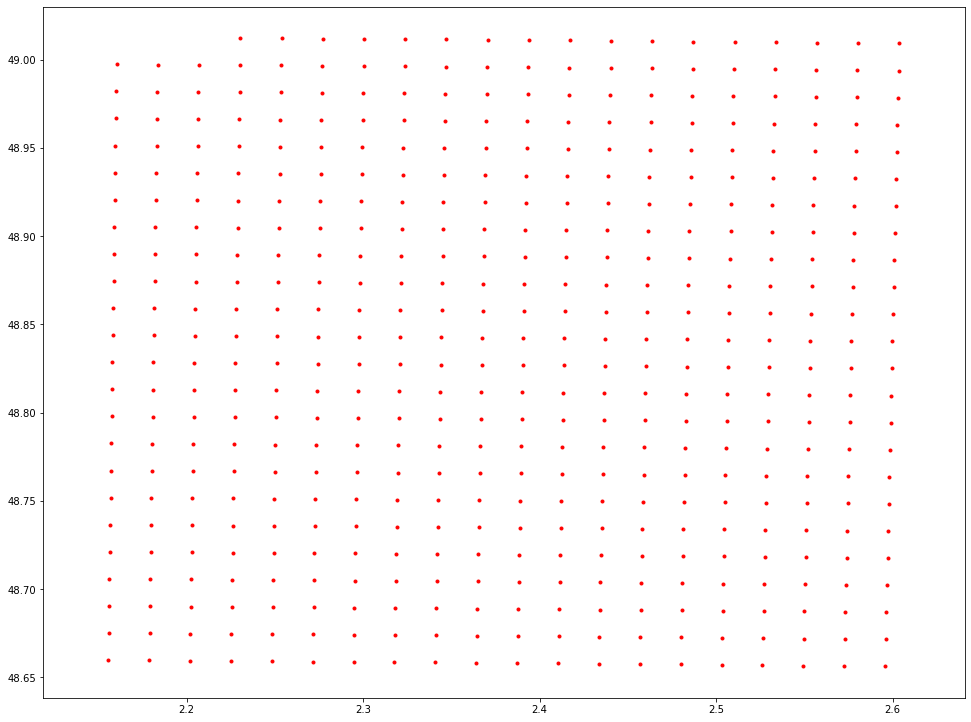

In [7]:
fig = plt.figure(figsize=[2*6.4, 2*4.8])
ax = fig.add_axes([0, 0, 1, 1])
ax.set_aspect('equal', adjustable='datalim')
plt.plot([g[0] for g in gridpoints_cut], [g[1] for g in gridpoints_cut], ".", color="red")
# gridpoints_cut

### Population density

In [8]:
# https://medium.com/@danielmoyo/raster-data-in-python-part-i-reading-and-visualising-raster-data-95cb072fcbfa
import rasterio
import matplotlib.pyplot as plt

for placeid, placeinfo in cities.items():
    raster_path = datapath + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
    pop_raster = rasterio.open(raster_path)
    
    cities[placeid]["bbox"] = location.bounds

    def plot_raster(arr, title=None, figsize=(30,10)):
        """ helper function to plot a raster array """
        fig, ax = plt.subplots(figsize=figsize)
        plt.imshow(arr)
        plt.colorbar()
        plt.title(f'{title}')
        plt.xlabel('Column #')
        plt.ylabel('Row #')
        return fig, ax

    pop_data = pop_raster.read(1)
    pop_data[pop_data<0] = 0
    pop_count = pop_data[pop_data>0].sum()
    plot_raster(pop_data, title=pop_count)

RasterioIOError: ../data/populationdensity/fra_ppp_2020_UNadj.tif: No such file or directory

In [ ]:
# https://stackoverflow.com/questions/50191648/gis-geotiff-gdal-python-how-to-get-coordinates-from-pixel
# https://gdal.org/api/gdaldataset_cpp.html#_CPPv4N11GDALDataset15GetGeoTransformEPd

# Problems:
# https://gis.stackexchange.com/questions/331908/notimplementederror-wrong-number-or-type-of-arguments-for-overloaded-function
# https://gis.stackexchange.com/questions/44040/osr-python-testsr-importfromepsg4326-returns-empty-spatial-reference
# https://www.programcreek.com/python/example/58591/osgeo.osr.SpatialReference


def generate_latlons(raster_path):
    # open the dataset and get the geo transform matrix
    ds = gdal.Open(raster_path) 
    xoffset, px_w, rot1, yoffset, px_h, rot2 = ds.GetGeoTransform()
    ds_arr = ds.ReadAsArray()
    
    x_arr = np.arange(0, ds_arr.shape[0], 1)
    x_arr.shape = (len(x_arr), 1)
    x_arr = np.repeat(x_arr, [ds_arr.shape[1]], axis=1)
    
    y_arr = np.arange(0, ds_arr.shape[1], 1)
    y_arr.shape = (1, len(y_arr))
    y_arr = np.repeat(y_arr, [ds_arr.shape[0]], axis=0)
    
    # supposing x and y are your pixel coordinate this 
    # is how to get the coordinate in space.
    lon_arr = xoffset + px_w * y_arr + rot1 * x_arr + px_w / 2.0
    lat_arr = yoffset + px_h * y_arr + rot2 * x_arr + px_h / 2.0
    
    return(lat_arr, lon_arr)

for placeid, placeinfo in cities.items():
    raster_path = datapath + densityfolder + "/" + placeinfo['countryid'] + "_ppp_2020_UNadj.tif"
    pop_raster = rasterio.open(raster_path)
    (lat, lon) = generate_latlons(raster_path)
    
# To do: only read the relevant window
# https://medium.com/@danielmoyo/raster-data-in-python-part-ii-working-with-geographic-coordinates-a368708de5f2

In [ ]:
indices = np.where(pop_data == pop_data.max())
c_x = indices[0].item()
c_y = indices[1].item()

delta = 70
plot_raster(pop_data[c_x-delta:c_x+delta, c_y-delta:c_y+delta], title=pop_count)